---
---

# Semantic Segmentation 실습  
[Inception Modules Enhance Brain Tumor Segmentation](https://www.frontiersin.org/articles/10.3389/fncom.2019.00044/full)  

BraTS2020 데이터(T1W, T1-CE, T2, FLAIR)를 이용하여  
Brain Tumor 영역을 segmentation하는 모델 실습

------

---



## 0. 데이터셋 소개

### About
  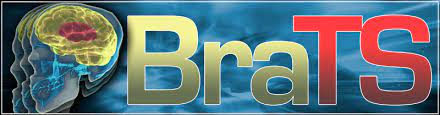
  
  BraTS has always been focusing on the evaluation of state-of-the-art methods for the segmentation of brain tumors in multimodal magnetic resonance imaging (MRI) scans. BraTS 2020 utilizes multi-institutional pre-operative MRI scans and primarily focuses on the segmentation (Task 1) of intrinsically heterogeneous (in appearance, shape, and histology) brain tumors, namely gliomas.

### Image  

이미지는 subject별 T1-weighted, T1W-CE, T2-weighted, FLAIR 영상 4개가 제공됨.

#### 사전 전처리

* **co-registered to the same anatomical template & interpolated to the same resolution (1 mm^3)**

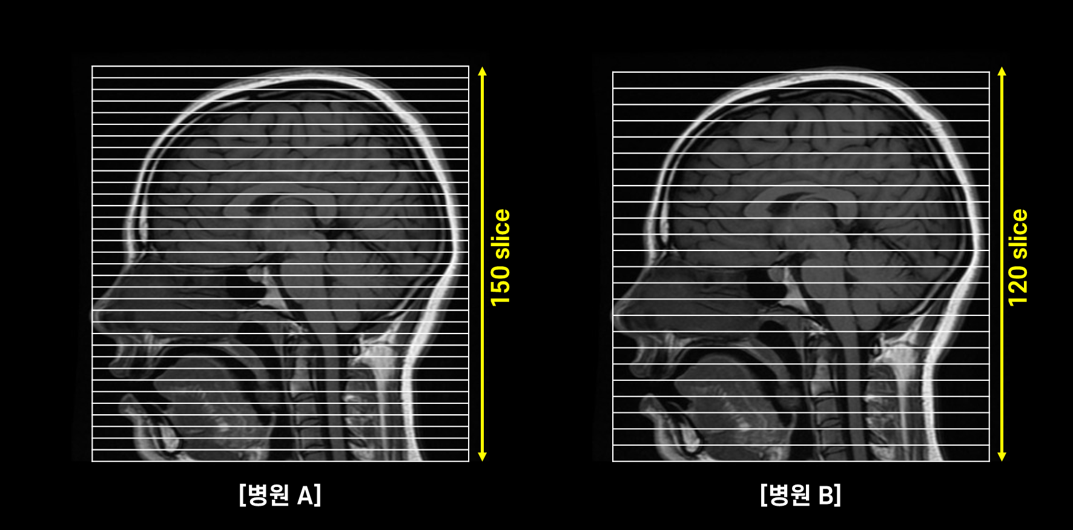

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;병원 혹은 MRI 장비 회사별 촬영 방식 차이로 인해 생성되는 데이터의 규격이 다름
-   영상의 slice 개수 (=dimension 차이)
-   해상도 (1 voxel = 1mm^3 or 0.8mm^3 ...)  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;각 데이터를 Brain Template에 맞게 조정하는 coregister 과정을 진행. 이 과정에서 모든 subject의 머리 형태가 전부 동일해짐.

* **skull-stripped**  
Tumor segmentation과 상관없는 skull은 이미지에서 제거  
![img](https://andysbrainbook.readthedocs.io/en/latest/_images/13_SkullStripping_BeforeAfter.png)

### Annotations
* the necrotic and non-enhancing tumor core (NCR/NET - label 1)
* the peritumoral edema  (ED -label 2)
* the GD-Enhancing Tumor (ET - label 3)

![img](https://media.arxiv-vanity.com/render-output/7283060/F1.png)  

### 논문
* whole tumor (WT) which encompasses all three intra-tumoral structures (i.e., label = 1∪2∪3)
* tumor core (TC) that contains all but the peritumoral edema (i.e., label = 1∪3)
* enhancing tumor (ET) (label = 3)  
  

이번 실습에서는 Whole Tumor(i.e., label = 1∪2∪3)인 1번으로 진행하며  
이에 따라 모델은 background와 tumor 영역 2개를 분할

## 1. 환경 설정

### 1-1.  Kaggle API 설정

Kaggle에서 다운로드한 kaggle.json파일을 업로드

In [ ]:
from google.colab import files
files.upload()

API 세팅

In [5]:
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

### 1-2. Kaggle로부터 데이터셋 다운로드  

---

다운로드 (소요시간: 약 1분이내)

In [11]:
%cd '/content'

/content


In [12]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [02:00<00:00, 44.9MB/s]
100% 4.16G/4.16G [02:00<00:00, 37.1MB/s]


#### 데이터 압축 해제  


In [ ]:
!unzip -qq brats20-dataset-training-validation.zip "BraTS2020_Train*Data/*" -d ./

./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_296/BraTS20_Training_296_t1ce.nii:  write error (disk full?).  Continue? (y/n/^C) 

다운로드한 압축파일은 제거

In [ ]:
!rm brats20-dataset-training-validation.zip

## 2. 데이터 처리

### 2-1. 라이브러리

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2, math, nibabel as nib
from glob import glob
from sklearn.model_selection import train_test_split
from ipywidgets import interact, interactive

plt.rcParams['figure.figsize'] = (8,8)

### 2-2. 데이터

In [ ]:
PATH = './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/' # 압축이 풀린 데이터의 경로

원본 데이터 리스트 작성

In [ ]:
df = pd.DataFrame(
    columns = ['ID', 'T1', 'T1CE', 'T2', 'FLAIR', 'MASK']
)
i=0

for subject in ( glob(PATH+'*Training*') ):
    if os.path.isdir(subject) == False: continue
    subject_id = subject.split('/')[-1]
    items = [subject_id.split('_')[-1],
                 subject + '/' + subject_id + '_t1.nii', # t1 강조
                 subject + '/' + subject_id + '_t1ce.nii', # t1 강조 + 조영제
                 subject + '/' + subject_id + '_t2.nii', # t2 강조
                 subject + '/' + subject_id + '_flair.nii', # flair
                 subject + '/' + subject_id + '_seg.nii' # label 데이터
                ]

    df.loc[i] = items; i+=1

df.head(5)

,ID,T1,T1CE,T2,FLAIR,MASK
0,084,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...
1,128,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...
2,136,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...
3,309,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...
4,033,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...,./BraTS2020_TrainingData/MICCAI_BraTS2020_Trai...


In [ ]:
# 파일명 통일을 위해 파일명 변경
# label 파일명 형식: BraTS20_Training_번호_seg.nii
!mv ./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii ./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii

mv: cannot stat './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii': No such file or directory


#### 원본 데이터

In [ ]:
# 데이터 탐색용 viewer 생성
# edema: 부종
# non-enhanceing core:
titles = ['T1', 'T1CE', 'T2', 'FLAIR', 'MASK']

@interact(index=np.arange(0,len(df)), slice=(0,155))
def viewer0(index=12, slice=75, non_enhancing_core=True, edema=True, enhancing_core=True):
    plt.figure(figsize=(20,8))
    for i, col in enumerate(titles):
        ff = nib.load(df[col].loc[index]).get_fdata()[:,:,slice]

        if i==4:
            if non_enhancing_core==False:  ff[np.where(ff==1)] = 0
            if edema==False             :  ff[np.where(ff==2)] = 0
            if enhancing_core==False     : ff[np.where(ff==4)] = 0

        plt.subplot(241+i)
        plt.title('Ground Truth' if titles[i]=='MASK' else titles[i])
        plt.imshow(ff, cmap='gray' if i!=4 else 'jet'); plt.axis('off')
    plt.show()
    plt.close('all')

interactive(children=(Dropdown(description='index', index=12, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1…

(참고)
index=157을 보면 FLAIR 데이터가 잘려 있는 것을 알 수 있음.  
제대로 된 학습을 위해서는 해당 유형의 데이터를 학습에서 배제하고 진행해야함.

### 2-3. Preprocessing

전처리 데이터 출력 경로 생성 및 데이터 목록 작성

In [ ]:
dfs = []
#!rm -r output
os.mkdir('output')
for path in ['output/train', 'output/valid', 'output/test']:
    try:
        os.mkdir(path)
        os.mkdir(path+'/X')
        os.mkdir(path+'/Y')

    except:
        print('pass')

    finally:
        train_df, vt_df   = train_test_split(df, test_size=0.2)
        valid_df, test_df = train_test_split(vt_df, test_size=0.5)
        dfs = [train_df, valid_df, test_df]

In [ ]:
from tensorflow.keras.utils import to_categorical
import multiprocessing as mp
import tqdm.notebook as tqdm

데이터 전처리 함수

1.   obtaining the bounding box of the brain in each image, and extracting the selected portion of the image, effectively zooming in on the brain and disregarding excess background pixels,   
2.   re-sizing the cropped image to 128 x 128 pixels,   
3.   removing images which contained no tumor regions in the ground truth segmentation,   
4.   applying an intensity windowing function to each image such that the lowest 1% and highest 99% pixels were mapped to 0 and 255, respectively  
5.   normalizing all images by subtracting the mean and dividing by the standard deviation of the dataset.

In [ ]:
# 전체 영역에서 Tumor에 해당하는 픽셀의 비중이 1% 미만이면 해당 슬라이스는 배제
def calc_ratio(src, threshold=0.01):
    classes, counts = np.unique(src, return_counts=True)
    del(src)
    ratio = np.sum(counts[1:])/(240**2)
    return ratio > threshold

In [ ]:
def Worker(path, dataframe):
    print('-',end='')
    indices = dataframe.index
    for idx in tqdm.tqdm(indices):
        ID = dataframe['ID'].loc[idx]

        # Subject별 4개 이미지 로드
        img_T1    = nib.load(dataframe['T1'].loc[idx]).get_fdata()
        img_T1CE  = nib.load(dataframe['T1CE'].loc[idx]).get_fdata()
        img_T2    = nib.load(dataframe['T2'].loc[idx]).get_fdata()
        img_FLAIR = nib.load(dataframe['FLAIR'].loc[idx]).get_fdata()

        # Subject 라벨 데이터 로드
        msk       = nib.load(dataframe['MASK'].loc[idx]).get_fdata()

        #GD-Enhancing tumor가 4로 표기되어 있으므로 이를 3으로 조정
        msk[np.where(msk==4)] = 3

        for j in range(msk.shape[-1]):
            target_mask = msk[:,:,j]

            # Preprocessing (3)
            if calc_ratio(target_mask):
                for i, img in enumerate([img_T1, img_T1CE, img_T2, img_FLAIR]):
                    if i==0: # Preprocessing (1)
                        img_out = img[:,:,j].copy()
                        img_out = (img_out/img_out.max()*255).astype(np.uint8)
                        x,y,w,h = cv2.boundingRect(img_out)

                        combined = np.empty((128, 128, 4), np.float32)
                        label    = np.zeros((128, 128), np.uint8)

                        label0    = target_mask[y:y+h, x:x+w].copy()
                        labels    = to_categorical(label0, num_classes=4) * 255

                        for k in range(1,4):
                            temp = cv2.resize(labels[:,:,k].copy(), (128, 128), cv2.INTER_AREA)
                            label[np.where(temp!=0)] = k
                            del(temp)

                        del(img_out, target_mask)

                    # Preprocessing (2)
                    img = cv2.resize( img[y:y+h, x:x+w, j], (128, 128), cv2.INTER_AREA )

                    # Preprocessing (4)
                    img = (img-img.mean())/(img.std())
                    combined[:,:,i] = img.copy()
                    del(img)

                np.save(path+f'/X/{idx}_{j}.npy',combined)
                np.save(path+f'/Y/{idx}_{j}.npy',label)
                del(label)

        del(img_T1, img_T1CE, img_T2, img_FLAIR, msk)

전처리 진행 (약 5분정도 소요)

In [ ]:
Worker('output/train', train_df)
Worker('output/valid', valid_df)
Worker('output/test', test_df)

-

  0%|          | 0/295 [00:00<?, ?it/s]

-

  0%|          | 0/37 [00:00<?, ?it/s]

-

  0%|          | 0/37 [00:00<?, ?it/s]

### 2-4. 데이터 전처리 결과 확인

In [ ]:
titles = ['T1', 'T1CE', 'T2', 'FLAIR']

@interact(index=(0,100))
def viewer(path='output/train', index=5, non_enhancing_core=True, edema=True, enhancing_core=True):
    img_path = glob(path+'/X/*.npy')[index]
    img = np.load(img_path)
    msk = np.load(img_path.replace('X','Y'))

    if non_enhancing_core==False:
        msk[np.where(msk==1)] = 0
    if edema==False:
        msk[np.where(msk==2)] = 0
    if enhancing_core==False:
        msk[np.where(msk==3)] = 0


    plt.figure(figsize=(20,8))
    for i in range(1,5):
        plt.subplot(240+i); plt.title(titles[i-1]) ; plt.imshow(img[:,:,i-1], cmap='gray'); plt.axis('off')
    plt.subplot(245); plt.title('Ground Truth'); plt.imshow(msk, vmin=0, vmax=3); plt.axis('off')#; plt.colorbar()
    plt.show()
    print('')
    print(np.unique(msk))

interactive(children=(Text(value='output/train', description='path'), IntSlider(value=5, description='index'),…

전처리한 데이터 리스트 작성

In [ ]:
train_df = pd.DataFrame(columns=['img','msk'])
valid_df = pd.DataFrame(columns=['img','msk'])
test_df = pd.DataFrame(columns=['img','msk'])

for i, img in enumerate(glob('output/train/X/*')):
    train_df.loc[i] = [img, img.replace('X', 'Y')]

for i, img in enumerate(glob('output/valid/X/*')):
    valid_df.loc[i] = [img, img.replace('X', 'Y')]

for i, img in enumerate(glob('output/test/X/*')):
    test_df.loc[i] = [img, img.replace('X', 'Y')]

데이터

In [ ]:
num_classes = 2 #Background와 Tumor 영역을 분할하므로 클래스 개수는 2개

In [ ]:
from tensorflow.keras.utils import to_categorical, Sequence

class DataLoader(Sequence):
    def __init__(self, dataframe, batch_size, shuffle=False): # DataLoader 초기화
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.indices = self.dataframe.index

    def __len__(self): # DataLoader에서 제공할 데이터 개수 (=subject 수)
        return math.ceil(len(self.dataframe) / self.batch_size)

    def __getitem__(self, idx): #인덱스를 입력하면 해당되는 데이터를 전달하는 메소드
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_x = np.empty( ( len(indices), 128, 128, 4), dtype=np.float32 )
        batch_y = np.empty( ( len(indices), 128, 128, num_classes), dtype=np.float32 )
        for i, index in enumerate(indices):
            X, Y = map(lambda x: np.load(x), self.dataframe.loc[index])
            Y[np.where(Y!=0)] = 1
            batch_x[i] = X
            batch_y[i] = to_categorical(Y, num_classes=num_classes)

        return batch_x, batch_y

    # epoch이 끝날때마다 실행: shuffle용
    def on_epoch_end(self):
        self.indices = np.arange(len(self.dataframe))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

데이터는 batch size 32로 모델 학습에 입력됨

In [ ]:
batch_size = 32

Train / Validation / Test 데이터에 대한 DataLoader 선언

In [ ]:
train_data = DataLoader(train_df, batch_size, shuffle=True)
valid_data = DataLoader(valid_df, batch_size, shuffle=False)
test_data  = DataLoader(test_df, batch_size, shuffle=False)

## 3. Modeling

![img](https://www.frontiersin.org/files/Articles/469269/fncom-13-00044-HTML/image_m/fncom-13-00044-g001.jpg)  
논문에서는 Inception 모듈을 적용한 U-Net 모델을 설계

#### U-Net Modules

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models, layers, applications

In [ ]:
class Contract(layers.Layer): #contract path 모듈
    def __init__(self, output_feature=32, **kwargs):
        super(Contract, self).__init__(**kwargs)
        self.output_feature = output_feature #출력 데이터 채널 수

    def build(self, input_shape): #사용할 레이어를 선언하는 메소드
        self.Conv1 = layers.Conv2D(self.output_feature,(3,3), padding='same', activation='relu' )
        self.Conv2 = layers.Conv2D(self.output_feature,(3,3), padding='same', activation='relu' )
        self.MaxPooling = layers.MaxPooling2D(2)
        super(Contract, self).build(input_shape)

    def call(self, x): # 데이터 흐름(레이어 to 레이어)을 정의, 데이터는 call 메소드를 통해 연산
        x1 = self.Conv1(x)
        x1 = self.Conv2(x1)
        return self.MaxPooling(x1), x1

class Expand(layers.Layer): #expanding path 모듈
    def __init__(self, output_feature=32, **kwargs):
        super(Expand, self).__init__(**kwargs)
        self.output_feature = output_feature #출력 데이터 채널 수

    def build(self, input_shape): #사용할 레이어를 선언하는 메소드
        self.Conv1  = layers.Conv2D(self.output_feature,(3,3), padding='same', activation='relu' )
        self.Conv2  = layers.Conv2D(self.output_feature,(3,3), padding='same', activation='relu' )
        super(Expand, self).build(input_shape)

    def call(self, X): # 데이터 흐름(레이어 to 레이어)을 정의, 데이터는 call 메소드를 통해 연산
        x = layers.Concatenate()(X)
        x1 = self.Conv1(x)
        x1 = self.Conv2(x1)
        return x1

class Inception(layers.Layer): #inception 모듈
    def __init__(self, output_feature=32, mode='contract', **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.output_feature = output_feature #출력 데이터 채널 수
        self.mode = mode
        assert output_feature%4==0

    def build(self, input_shape): #사용할 레이어를 선언하는 메소드
        self.path1_conv11   = layers.Conv2D(self.output_feature//4,(1,1), padding='same', activation='relu' )

        self.path2_conv11   = layers.Conv2D(self.output_feature//4,(1,1), padding='same', activation='relu' )
        self.path2_conv33   = layers.Conv2D(self.output_feature//4,(3,3), padding='same', activation='relu' )

        self.path3_conv11   = layers.Conv2D(self.output_feature//4,(1,1), padding='same', activation='relu' )
        self.path3_conv33_1 = layers.Conv2D(self.output_feature//4,(3,3), padding='same', activation='relu' )
        self.path3_conv33_2 = layers.Conv2D(self.output_feature//4,(3,3), padding='same', activation='relu' )

        self.path4_conv33   = layers.Conv2D(self.output_feature//4,(3,3), padding='same', activation='relu' )
        self.path4_conv11   = layers.Conv2D(self.output_feature//4,(1,1), padding='same', activation='relu' )

        self.Batch          = layers.BatchNormalization()
        super(Inception, self).build(input_shape)

    def call(self, x): # 데이터 흐름(레이어 to 레이어)을 정의, 데이터는 call 메소드를 통해 연산
        path1 = self.path1_conv11(x)

        path2 = self.path2_conv11(x)
        path2 = self.path2_conv33(path2)

        path3 = self.path3_conv11(x)
        path3 = self.path3_conv33_1(path3)
        path3 = self.path3_conv33_2(path3)

        path4 = self.path4_conv33(x)
        path4 = self.path4_conv11(path4)

        together = layers.Concatenate()([path1, path2, path3, path4])

        return self.Batch(together)

#### Build U-Net

In [ ]:
depth = 32

In [ ]:
#Input
###############################################################################################
layer1 = layers.Input(shape=(128,128,4), name='Input_layer')

# Contracting Path
###############################################################################################
stage1_1                = Inception(depth*1, name='Stage1_Inception_32')(layer1)
stage1_2, stage1_2_skip = Contract( depth*2,  name='Stage1_Contract')(stage1_1)       # Skip-connection 데이터 존재!

stage2_1                = Inception(depth*2, name='Stage2_Inception_64')(stage1_2)
stage2_2, stage2_2_skip = Contract( depth*4,name='Stage2_Contract')(stage2_1)         # Skip-connection 데이터 존재!

stage3_1                = Inception(depth*4,name='Stage3_Inception_128')(stage2_2)
stage3_2, stage3_2_skip = Contract( depth*8,name='Stage3_Contract')(stage3_1)         # Skip-connection 데이터 존재!

stage4_1                = Inception(depth*8,name='Stage4_Inception_256')(stage3_2)
stage4_2, stage4_2_skip = Contract( depth*16,name='Stage4_Contract')(stage4_1)        # Skip-connection 데이터 존재!

stage5_1                = Inception(512,name='Stage5_Inception_512_1')(stage4_2)

# Bottleneck
###############################################################################################

bottleneck              = layers.Conv2D(1024, (3,3), padding='same', activation='relu', name='Bottleneck')(stage5_1)

# Expanding Path
###############################################################################################
stage5_2                = Inception(512,name='Stage5_Inception_512_2')(bottleneck)

stage5to4               = layers.Conv2DTranspose(512, (3,3), strides=(2,2), padding='same', activation='relu', name='Stage5_to_4')(stage5_2)
stage4_3                = Expand(256,   name='Stage4_Expand')([stage5to4, stage4_2_skip])
stage4_4                = Inception(256, name='Stage4_Inception_256_2')(stage4_3)

stage4to3               = layers.Conv2DTranspose(256, (3,3), strides=(2,2), padding='same', activation='relu', name='Stage4_to_3')(stage4_4)
stage3_3                = Expand(128,   name='Stage3_Expand')([stage4to3, stage3_2_skip])
stage3_4                = Inception(128, name='Stage3_Inception_128_2')(stage3_3)

stage3to2               = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation='relu', name='Stage3_to_2')(stage3_4)
stage2_3                = Expand(64,   name='Stage2_Expand')([stage3to2, stage2_2_skip])
stage2_4                = Inception(64, name='Stage2_Inception_64_2')(stage2_3)

stage2to1               = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', name='Stage2_to_1')(stage2_4)
stage1_3                = Expand(64,   name='Stage1_Expand')([stage2to1, stage1_2_skip])
stage1_4                = Inception(32, name='Stage1_Inception_32_2')(stage1_3)

#Output
###############################################################################################
output                  = layers.Conv2D(num_classes, (1,1), activation='softmax')(stage1_3)


# 모델 설계
Model = models.Model(layer1, output)

#### Model architecture

In [ ]:
#모델 정보
Model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_layer (InputLayer)    [(None, 128, 128, 4)]        0         []                            
                                                                                                  
 Stage1_Inception_32 (Incep  (None, 128, 128, 32)         2368      ['Input_layer[0][0]']         
 tion)                                                                                            
                                                                                                  
 Stage1_Contract (Contract)  ((None, 64, 64, 64),         55424     ['Stage1_Inception_32[0][0]'] 
                              (None, 128, 128, 64))                                               
                                                                                              

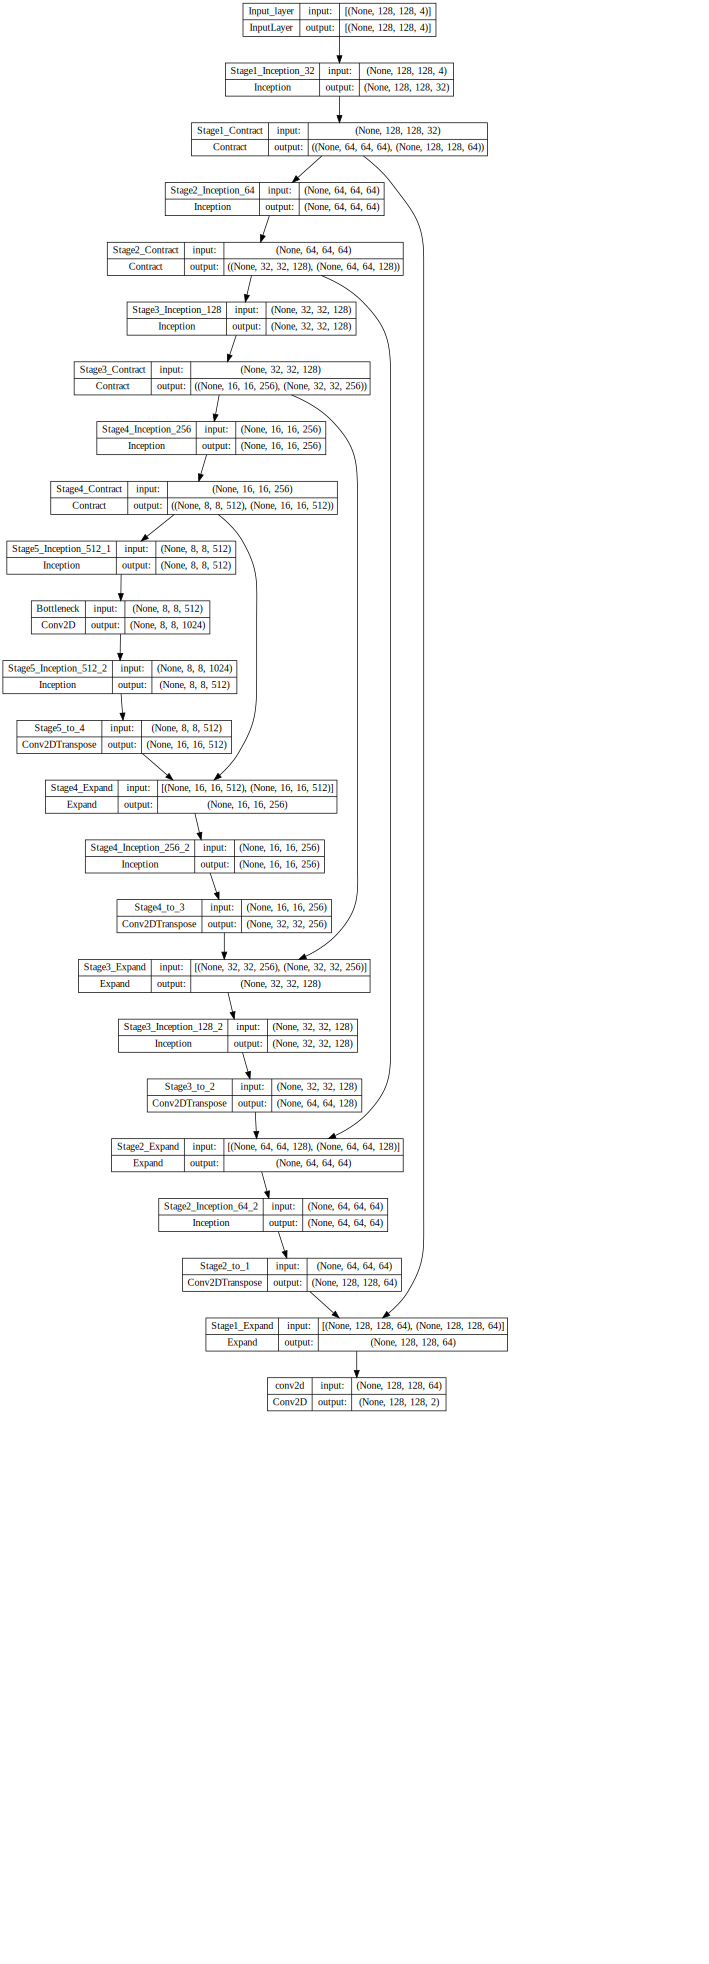

In [ ]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(Model, dpi=100, show_shapes=True,).create(prog='dot', format='svg'))

### Training

In [ ]:
epochs = 10
learning_rate = 1e-4

DICE 지표와 이를 활용한 loss function

In [ ]:
import tensorflow.keras.backend as K

@tf.function
def dice_coef(y_true, y_pred):
    y_true, y_pred = y_true[:,:,:,1:], y_pred[:,:,:,1:]
    epsilon = tf.keras.backend.epsilon()

    y_true_sum = tf.reduce_sum(y_true, axis=[1,2,3])
    y_pred_sum = tf.reduce_sum(y_pred, axis=[1,2,3])

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = y_true_sum + y_pred_sum

    dice = (2. * intersection + epsilon) / (union + epsilon)

    return K.mean(dice)

@tf.function
def dice_coef_loss(y_true, y_pred):
    return -K.log( dice_coef(y_true, y_pred) )

LR Scheduler를 이용해 학습율을 10epoch마다 감소

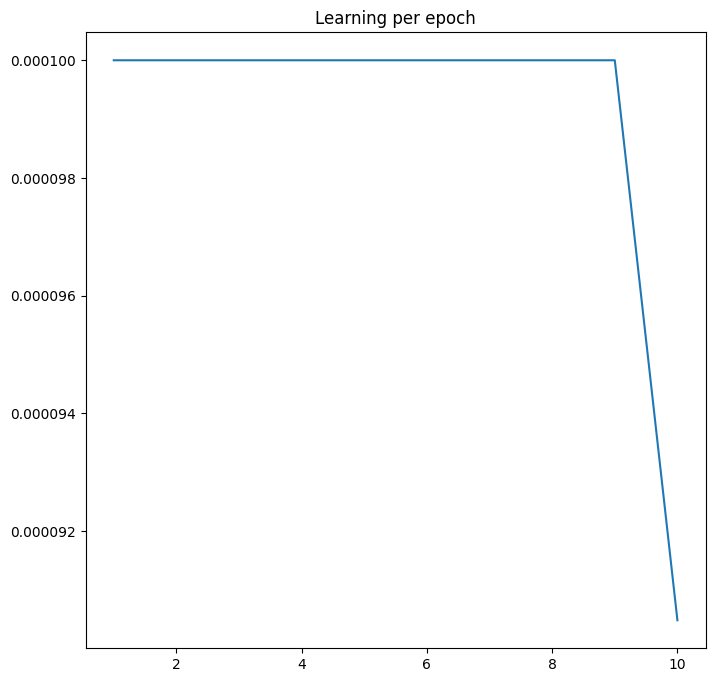

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

def LR_decay(epoch): #learning rate 감소 (10 epoch마다 감소)
    init_lr = learning_rate
    decay_step = 10
    return init_lr * tf.math.exp(-0.1*(epoch//decay_step))

a, b = np.arange(1, epochs+1), []
for i in a: b.append(LR_decay(i))
plt.title('Learning per epoch'); plt.plot(a,b)
plt.show()

모델 컴파일

In [ ]:
Model.compile(optimizer=Adam(learning_rate=learning_rate), #Adam
              loss = dice_coef_loss, #손실함수 : dice coefficient, loss
              metrics = [dice_coef]  #Metrics: dice_coefficient
)

학습 시작 (1 epoch 당 4분 30초)

In [ ]:
history = Model.fit(
    train_data, validation_data = valid_data, batch_size = batch_size, epochs=epochs,
    callbacks = [LearningRateScheduler(LR_decay), #learning rate 감소 (10 epoch마다 감소)
                ModelCheckpoint('./model_intra_tumoral.h5', monitor='val_loss', save_best_only=True, verbose=1)] #best model 가중치 저장
)

Epoch 1/10
440/440 [==============================] - ETA: 0s - loss: 0.1772 - dice_coef: 0.8576
Epoch 1: val_loss improved from inf to 0.12407, saving model to ./model_intra_tumoral.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


440/440 [==============================] - 270s 484ms/step - loss: 0.1772 - dice_coef: 0.8576 - val_loss: 0.1241 - val_dice_coef: 0.8834 - lr: 1.0000e-04
Epoch 2/10
440/440 [==============================] - ETA: 0s - loss: 0.0914 - dice_coef: 0.9127
Epoch 2: val_loss improved from 0.12407 to 0.11114, saving model to ./model_intra_tumoral.h5
440/440 [==============================] - 200s 454ms/step - loss: 0.0914 - dice_coef: 0.9127 - val_loss: 0.1111 - val_dice_coef: 0.8949 - lr: 1.0000e-04
Epoch 3/10
440/440 [==============================] - ETA: 0s - loss: 0.0815 - dice_coef: 0.9218
Epoch 3: val_loss improved from 0.11114 to 0.10340, saving model to ./model_intra_tumoral.h5
440/440 [==============================] - 201s 456ms/step - loss: 0.0815 - dice_coef: 0.9218 - val_loss: 0.1034 - val_dice_coef: 0.9018 - lr: 1.0000e-04
Epoch 4/10
440/440 [==============================] - ETA: 0s - loss: 0.0755 - dice_coef: 0.9274
Epoch 4: val_loss did not improve from 0.10340
440/440 [=====

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope
import Contract, Expand, Inception

# custom으로 선언한 class, function은 별도의 module 파일로 생성하여 불러오고, 함수는 모델을 불러오기 전에 사전에 선언을 해야함
# custom_objects의 dictionary 타입으로 key값으로 해당 클래스와 함수 이름을 작성하고 value 값으로 함수와 클래스를 호출 할 수 있도록 작성
custom_objects = {
    'Contract': Contract.Contract,
    'Expand': Expand.Expand,
    'Inception': Inception.Inception,
    'dice_coef_loss': dice_coef_loss,
    'dice_coef': dice_coef
}

with custom_object_scope(custom_objects):
    model = load_model('model_intra_tumoral.h5')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# 이전 학습 기록이 있다면 그 길이를 초기 에포크로 설정
initial_epoch = len(history.history['loss']) if 'history' in locals() else 0

# 추가로 학습할 에포크 수 설정
additional_epochs = 50  # 예: 50 에포크 추가
total_epochs = initial_epoch + additional_epochs

# 학습률 스케줄러 정의 (이전에 사용한 LR_decay 함수가 있다고 가정)
lr_scheduler = LearningRateScheduler(LR_decay)

# 새로운 ModelCheckpoint 콜백 정의
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/model_intra_tumoral_continued_{epoch:02d}.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# 모델 컴파일 (필요한 경우, 옵티마이저와 손실 함수가 변경되었을 수 있음)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 학습 계속하기
history = model.fit(
    train_data,
    validation_data=valid_data,
    batch_size=batch_size,
    epochs=total_epochs,
    initial_epoch=initial_epoch,
    callbacks=[lr_scheduler, checkpoint]
)

In [ ]:
history = Model.fit(
    train_data, validation_data = valid_data, batch_size = batch_size, epochs=epochs,
    callbacks = [LearningRateScheduler(LR_decay), #learning rate 감소 (10 epoch마다 감소)
                ModelCheckpoint('./model_intra_tumoral.h5', monitor='val_loss', save_best_only=True, verbose=1)] #best model 가중치 저장
)

Epoch 1/10
438/438 [==============================] - ETA: 0s - loss: 0.1440 - dice_coef: 0.8560
Epoch 1: val_loss improved from inf to 0.12476, saving model to ./model_intra_tumoral.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 255s 450ms/step - loss: 0.1440 - dice_coef: 0.8560 - val_loss: 0.1248 - val_dice_coef: 0.8752 - lr: 1.0000e-04
Epoch 2/10
438/438 [==============================] - ETA: 0s - loss: 0.0873 - dice_coef: 0.9126
Epoch 2: val_loss improved from 0.12476 to 0.10199, saving model to ./model_intra_tumoral.h5
438/438 [==============================] - 193s 439ms/step - loss: 0.0873 - dice_coef: 0.9126 - val_loss: 0.1020 - val_dice_coef: 0.8980 - lr: 1.0000e-04
Epoch 3/10
438/438 [==============================] - ETA: 0s - loss: 0.0821 - dice_coef: 0.9179
Epoch 3: val_loss improved from 0.10199 to 0.09786, saving model to ./model_intra_tumoral.h5
438/438 [==============================] - 194s 442ms/step - loss: 0.0821 - dice_coef: 0.9179 - val_loss: 0.0979 - val_dice_coef: 0.9021 - lr: 1.0000e-04
Epoch 4/10
438/438 [==============================] - ETA: 0s - loss: 0.0754 - dice_coef: 0.9247
Epoch 4: val_loss did not improve from 0.09786
438/438 [=====

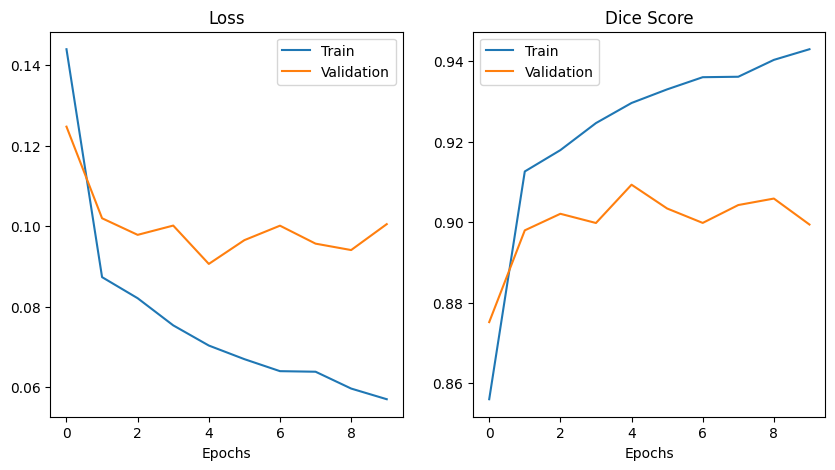

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(121); plt.title('Loss')
plt.xlabel('Epochs')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Validation'])

plt.subplot(122); plt.title('Dice Score')
plt.xlabel('Epochs')
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.legend(['Train', 'Validation'])

plt.show()

## Evaluation

val_loss가 가장 작았던 상태의 모델 가중치를 로드

In [ ]:
Model.load_weights('./model_intra_tumoral.h5')

#### Validation 데이터 평가  
---

In [ ]:
eval_valid = Model.evaluate(valid_data) # Evaluation

55/55 [==============================] - 8s 141ms/step - loss: 0.0906 - dice_coef: 0.9093


In [ ]:
rtns2 = Model.predict(valid_data) # Prediction

55/55 [==============================] - 7s 126ms/step


In [ ]:
@interact(batch=np.arange(len(valid_data)), index=np.arange(batch_size))
def Valid_Viewer(batch, index):
    img, label = valid_data[batch]

    plt.figure(figsize=(20,8))
    plt.subplot(241); plt.title('T1')          ; plt.imshow(  img[index,:,:,0], cmap='gray'); plt.axis('off')
    plt.subplot(242); plt.title('T1CE')        ; plt.imshow(  img[index,:,:,1], cmap='gray'); plt.axis('off')
    plt.subplot(243); plt.title('T2')          ; plt.imshow(  img[index,:,:,2], cmap='gray'); plt.axis('off')
    plt.subplot(244); plt.title('FLAIR')       ; plt.imshow(  img[index,:,:,3], cmap='gray'); plt.axis('off')
    plt.subplot(245); plt.title('Ground Truth'); plt.imshow(label[index].argmax(axis=-1)); plt.axis('off')
    plt.subplot(246); plt.title('Prediction')  ; plt.imshow(rtns2[batch*batch_size+index, :,:].argmax(axis=-1)); plt.axis('off')
    plt.show()


interactive(children=(Dropdown(description='batch', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

#### Test 데이터 평가  
---

In [ ]:
eval_test = Model.evaluate(test_data) # Evaluation

57/57 [==============================] - 8s 137ms/step - loss: 0.0826 - dice_coef: 0.9176


In [ ]:
rtns3 = Model.predict(test_data)

57/57 [==============================] - 7s 122ms/step


In [ ]:
@interact(batch=np.arange(len(test_data)), index=np.arange(batch_size))
def Test_Viewer(batch, index):
    img, label = test_data[batch]

    plt.figure(figsize=(20,8))
    plt.subplot(241); plt.title('T1')          ; plt.imshow(  img[index,:,:,0], cmap='gray'); plt.axis('off')
    plt.subplot(242); plt.title('T1CE')        ; plt.imshow(  img[index,:,:,1], cmap='gray'); plt.axis('off')
    plt.subplot(243); plt.title('T2')          ; plt.imshow(  img[index,:,:,2], cmap='gray'); plt.axis('off')
    plt.subplot(244); plt.title('FLAIR')       ; plt.imshow(  img[index,:,:,3], cmap='gray'); plt.axis('off')
    plt.subplot(245); plt.title('Ground Truth'); plt.imshow(label[index].argmax(axis=-1)); plt.axis('off')
    plt.subplot(246); plt.title('Prediction')  ; plt.imshow(rtns3[batch*batch_size+index, :,:].argmax(axis=-1)); plt.axis('off')
    plt.show()


interactive(children=(Dropdown(description='batch', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load and preprocess the dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Create the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=64)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test accuracy:", test_acc)


11490434/11490434 [==============================] - 2s 0us/step
Epoch 1/5
938/938 [==============================] - 9s 5ms/step - loss: 0.1838 - accuracy: 0.9435
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0531 - accuracy: 0.9837
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0373 - accuracy: 0.9885
Epoch 4/5
938/938 [==============================] - 4s 5ms/step - loss: 0.0285 - accuracy: 0.9909
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0336 - accuracy: 0.9891
Test accuracy: 0.9890999794006348
